Initial idea is to verify that press releases affect the stock price. 

1. Test that press releases affect the price
2. Get the press release of that stock for that day
    a. Do a sentiment analysis on the title
    b. Check if + sentiment sent the stock up or vice versa


Data gotten here: https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar

In [129]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import time

load_dotenv()
plt.style.use("dark_background")


pd.set_option("display.max_columns", None)

# Get the Catalyst events

In [2]:
# Load JSON from a file
with open("historical-catalyst-calendar.json", "r") as file:
    data = json.load(file)

data = data["data"]["data"]

In [3]:
clean_data = []

bad_keys = ["price_change_sparkline", "statuses"]

for item in data:
    for key in bad_keys:
        if key in item:
            del item[key]
    clean_data.append(item)

In [4]:
df = pd.DataFrame(clean_data)
good_cols = ["date", "note", "company_ticker"]
dfc = df[good_cols]

In [6]:
# df.to_csv("historical-catalyst-calendar.csv", index=False)

In [16]:
dfc.sort_values(by="company_ticker", inplace=True)

/var/folders/y6/38m_mn3x0hd4sx1rhttwsz540000gn/T/ipykernel_7928/369700472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc.sort_values(by="company_ticker",inplace=True)


In [17]:
# quick stats on the data
print("Sample length: ", len(dfc))

tickers = dfc["company_ticker"].unique()
print("Unique tickers ", len(dfc["company_ticker"].unique()))

Sample length:  24
Unique tickers  21


# Get the stock price

In [127]:
from polygon import RESTClient

polygon_api = os.getenv("PLOYGON_API")

In [128]:
client = RESTClient(api_key=polygon_api)

In [89]:
stock_data = []
counter = 0

for index, row in dfc.iterrows():

    if counter == 5:
        time.sleep(60)
        counter = 0

    ticker = row["company_ticker"]  # The specific ticker you're interested in
    # start_time = pd.to_datetime(row["date"]) - pd.Timedelta(1)
    # end_time = pd.to_datetime(row["date"]) + pd.Timedelta(1)

    start_time = row["date"]
    end_time = row["date"]
    print("getting data for ", ticker, start_time)

    # List Aggregates (Bars)
    aggs = []
    for a in client.list_aggs(
        ticker=ticker,
        multiplier=5,
        timespan="minute",
        from_=start_time,
        to=end_time,
    ):
        aggs.append(a)
    stock_data.append({"ticker": ticker, "date": start_time, "data": aggs})
    counter += 1

getting data for  ABVX 2024-10-03
getting data for  ATHE 2024-10-02
getting data for  AZN 2024-10-07
getting data for  BDTX 2024-10-07
getting data for  BFRI 2024-10-07
getting data for  BMY 2024-10-04
getting data for  BMY 2024-10-03
getting data for  GANX 2024-10-07
getting data for  IMRN 2024-10-04
getting data for  IONS 2024-10-03
getting data for  IONS 2024-10-01
getting data for  KRRO 2024-10-07
getting data for  KZIA 2024-10-02
getting data for  PDSB 2024-10-02
getting data for  PHVS 2024-10-05
getting data for  PSTV 2024-10-01
getting data for  RARE 2024-10-04
getting data for  RARE 2024-10-07
getting data for  RNA 2024-10-03
getting data for  SRRK 2024-10-07
getting data for  THTX 2024-10-03
getting data for  TOVX 2024-10-03
getting data for  URGN 2024-10-02
getting data for  VINC 2024-10-07


In [90]:
import pickle

with open("data_dict.pkl", "wb") as f:
    pickle.dump(stock_data, f)

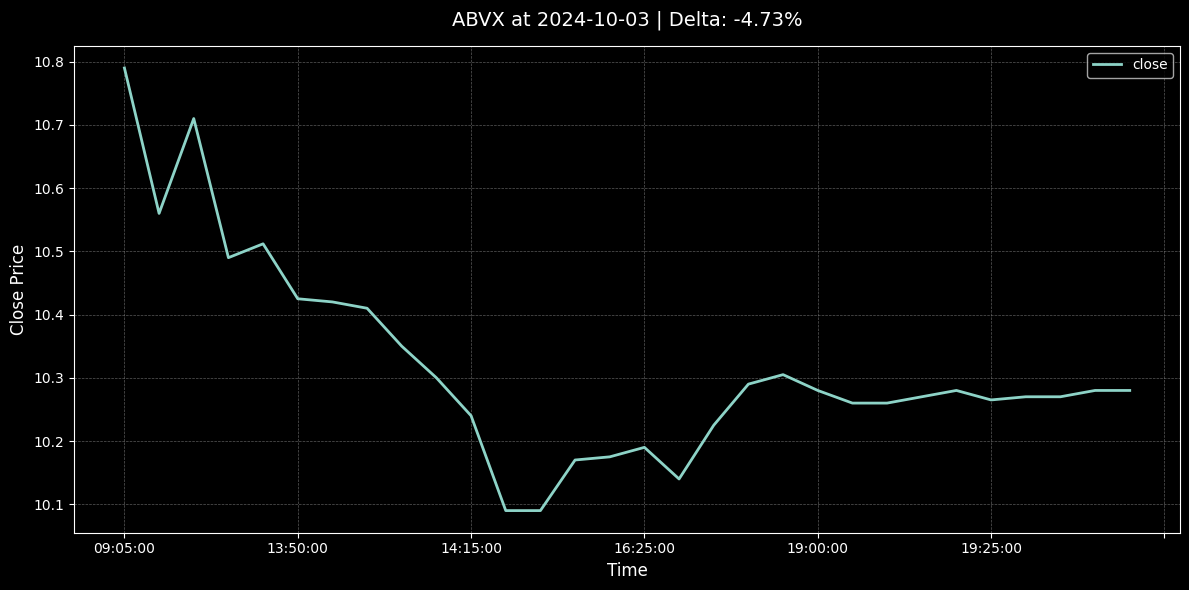

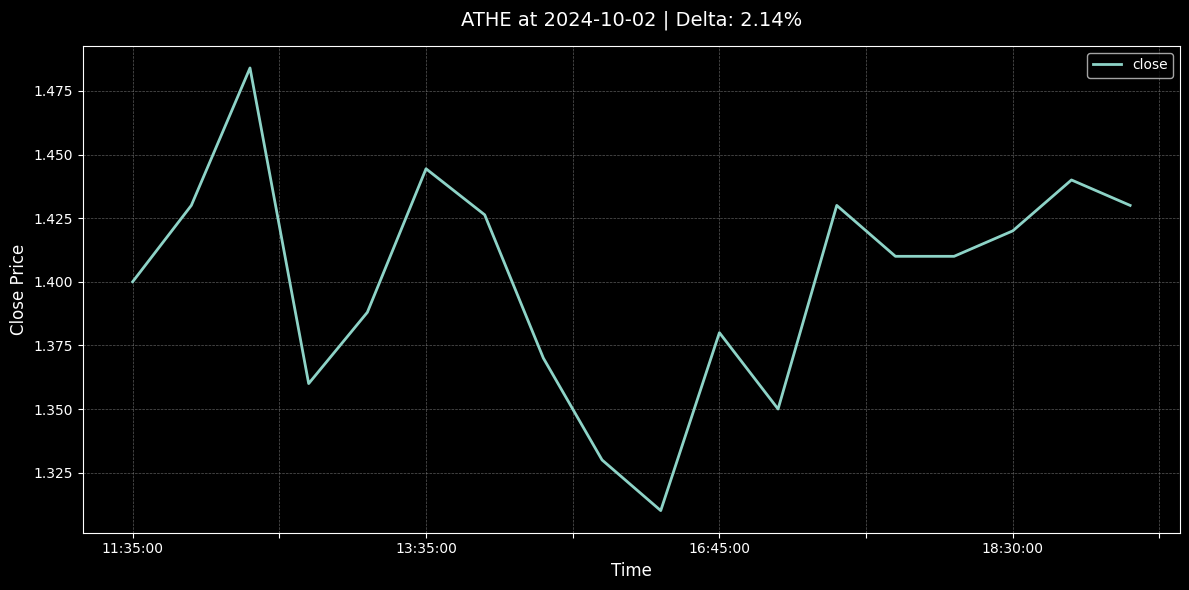

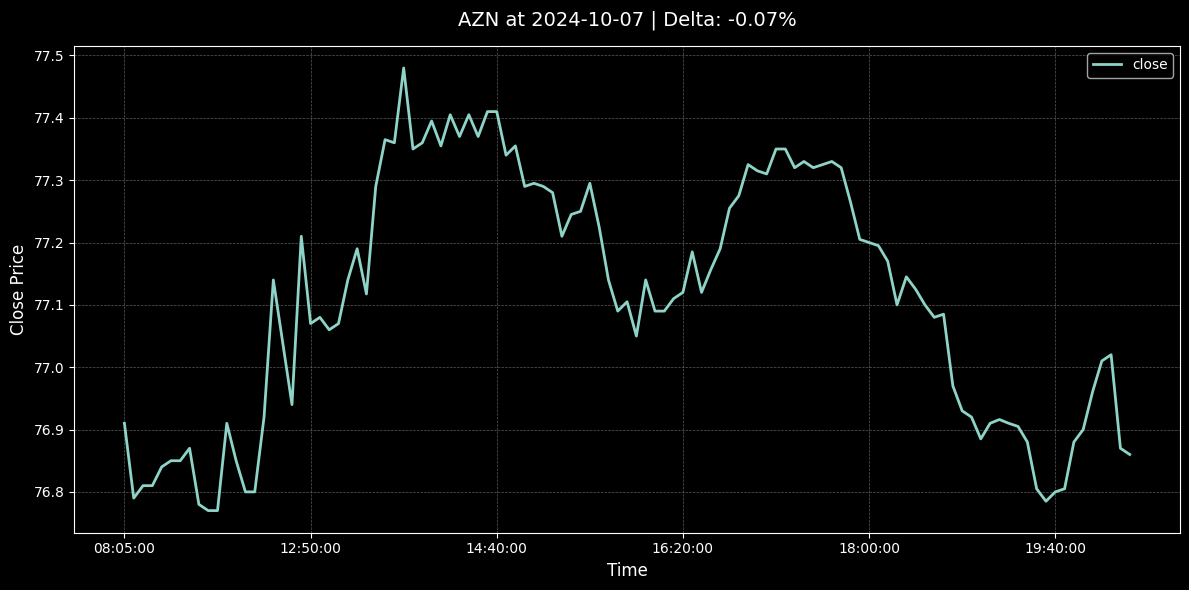

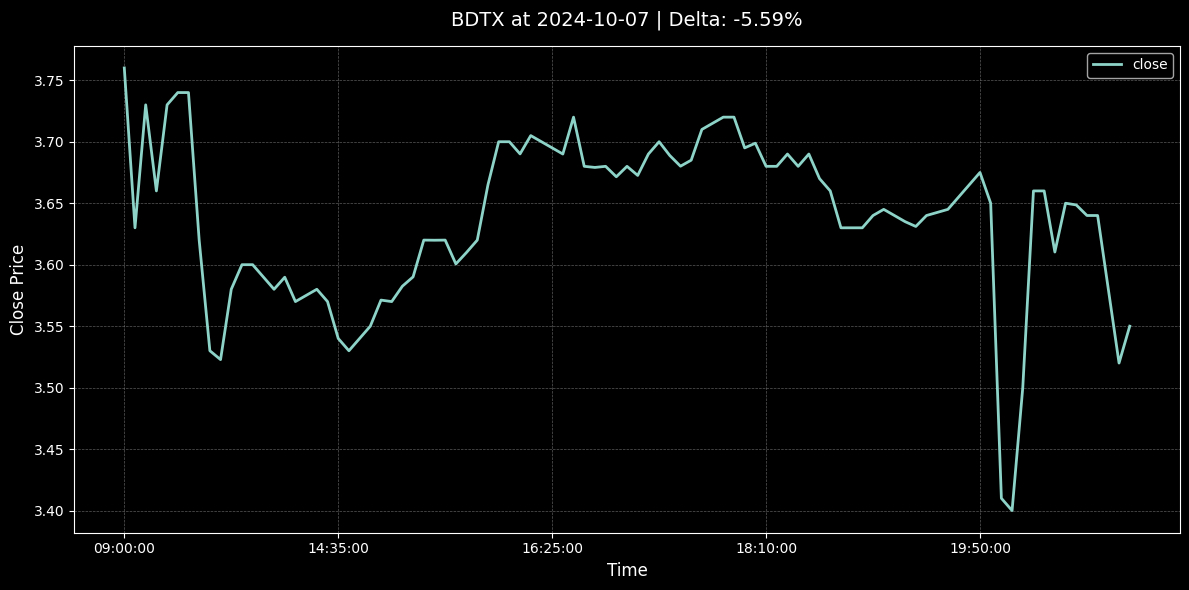

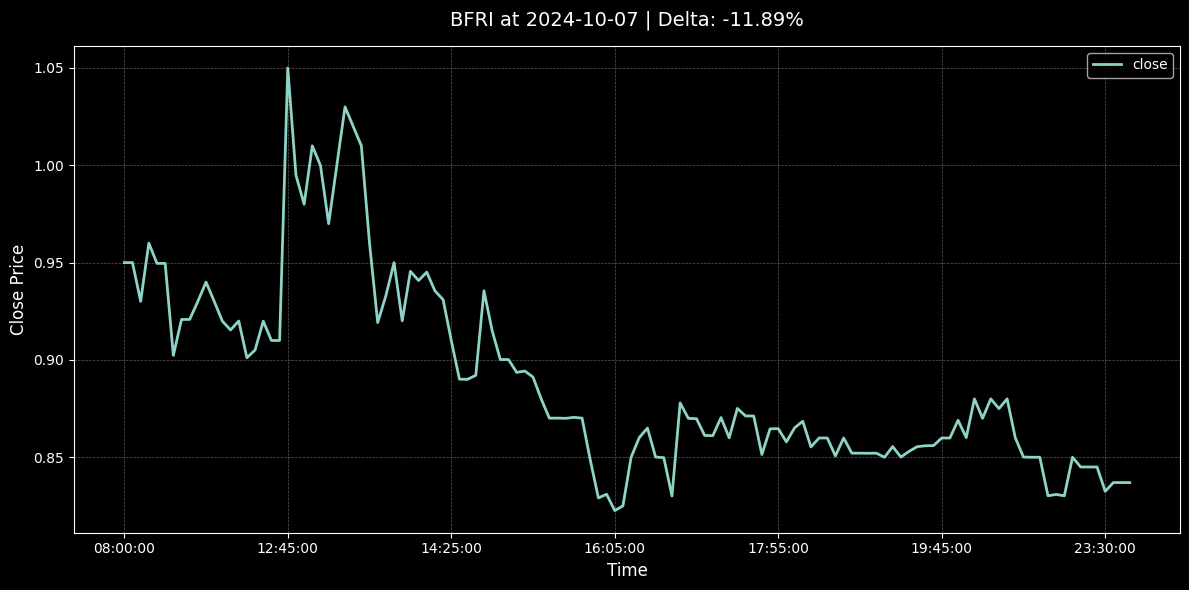

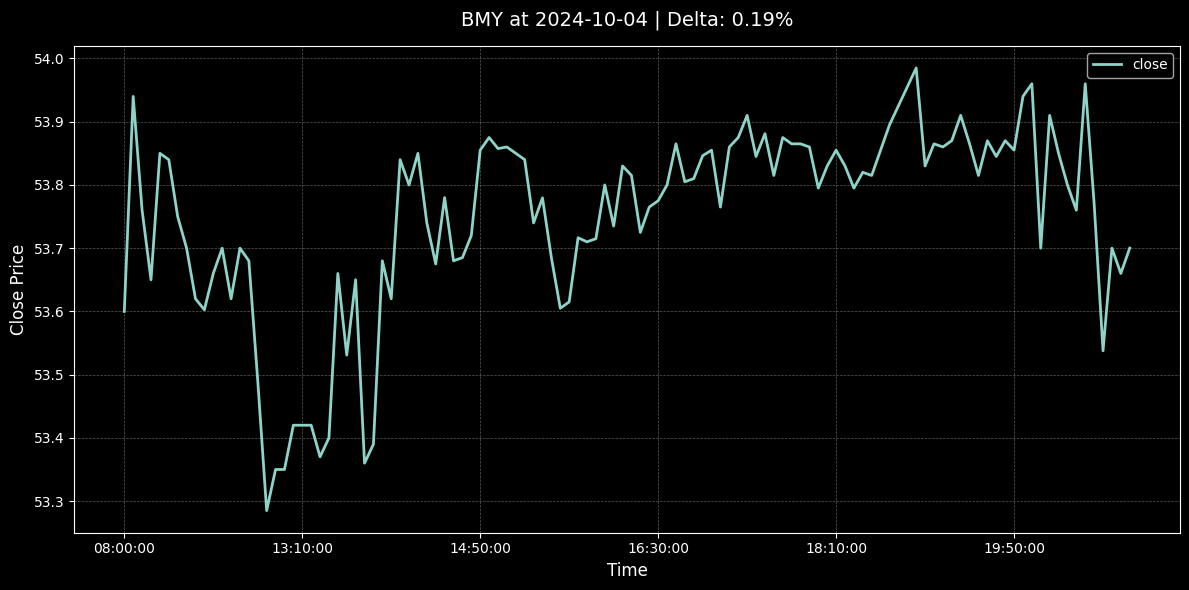

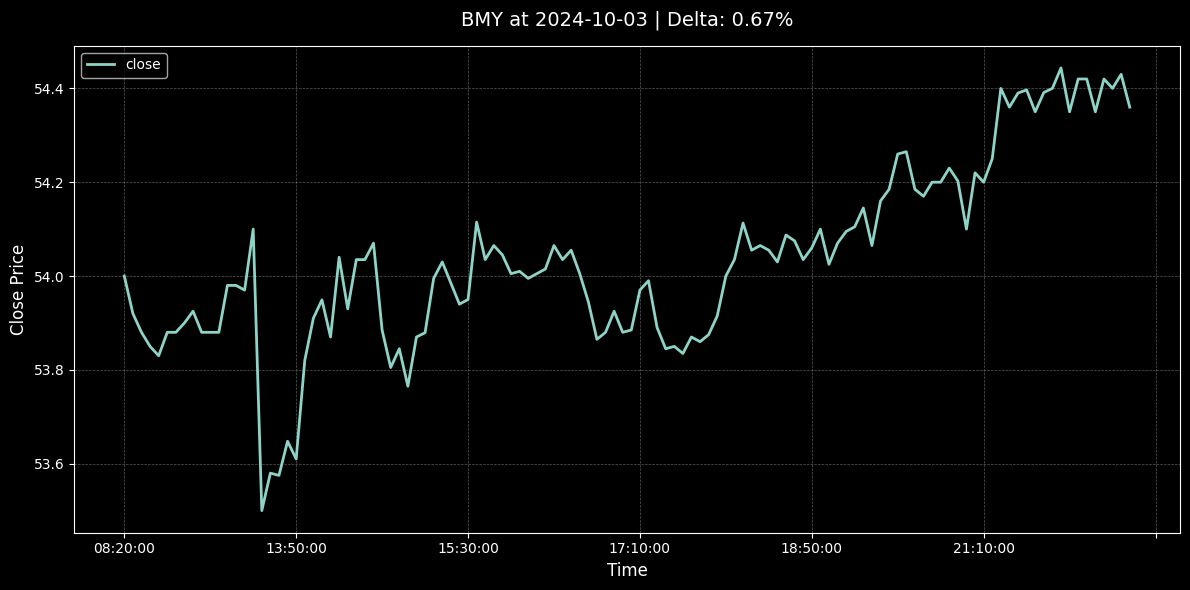

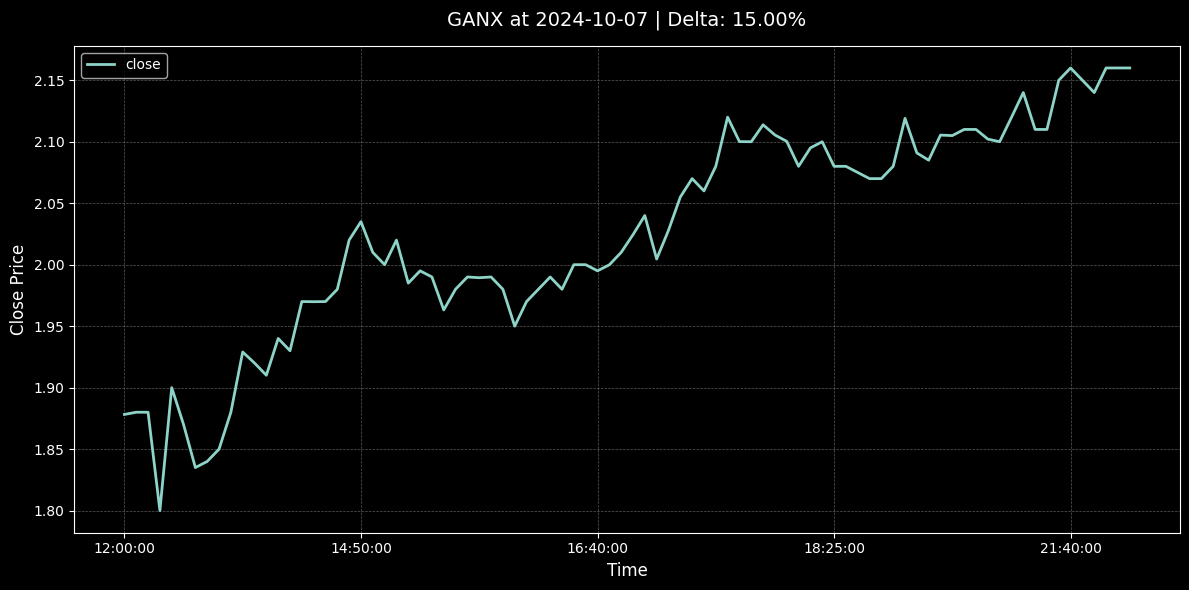

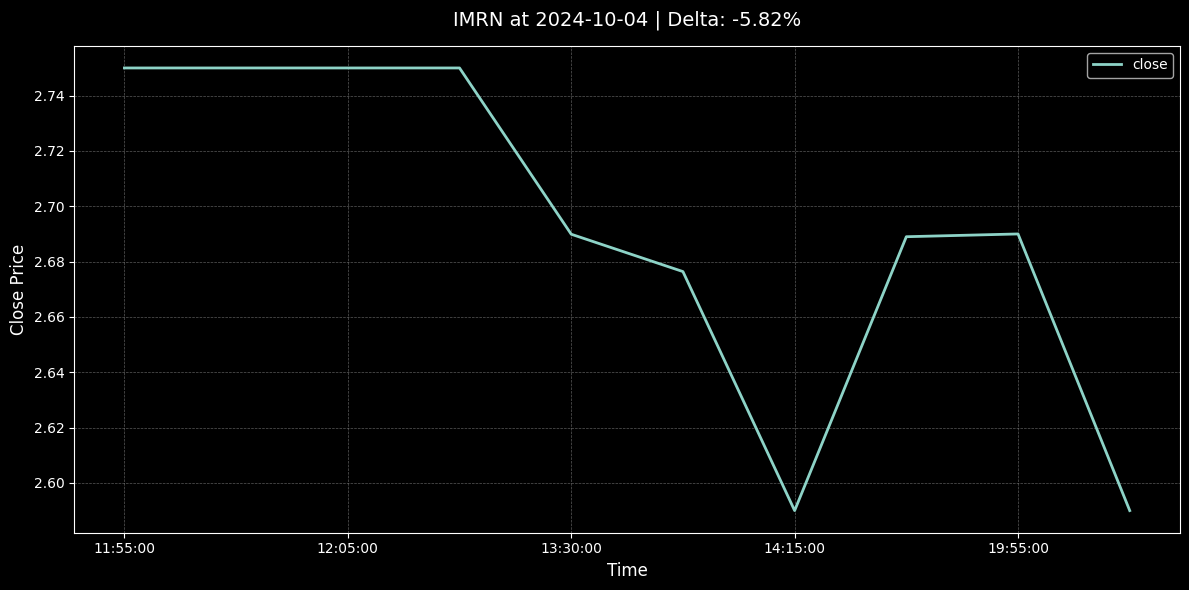

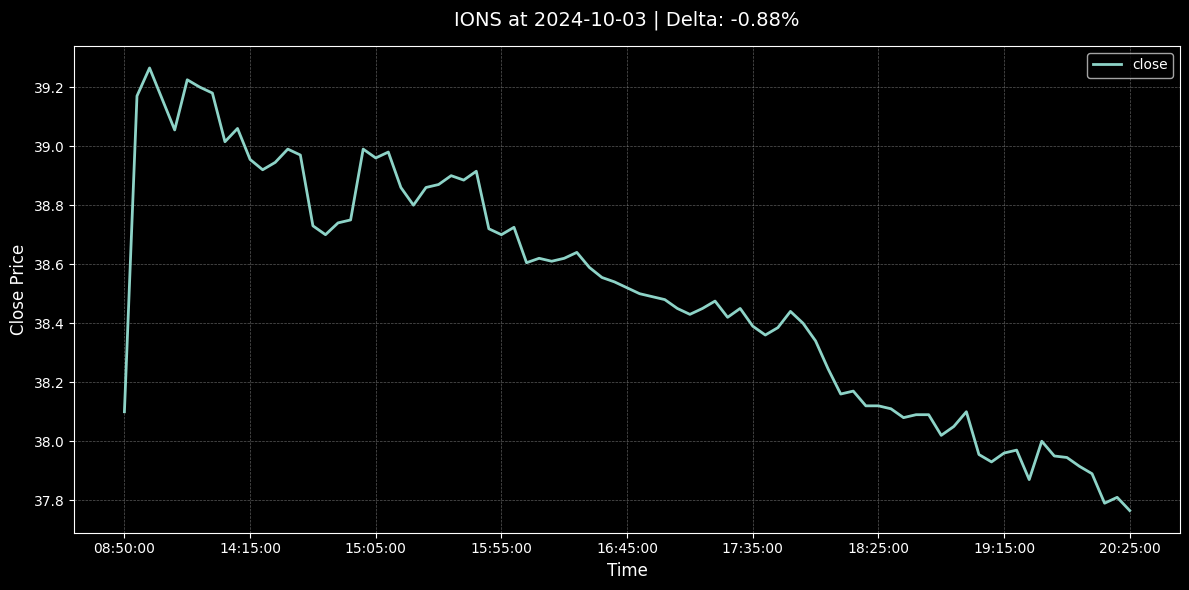

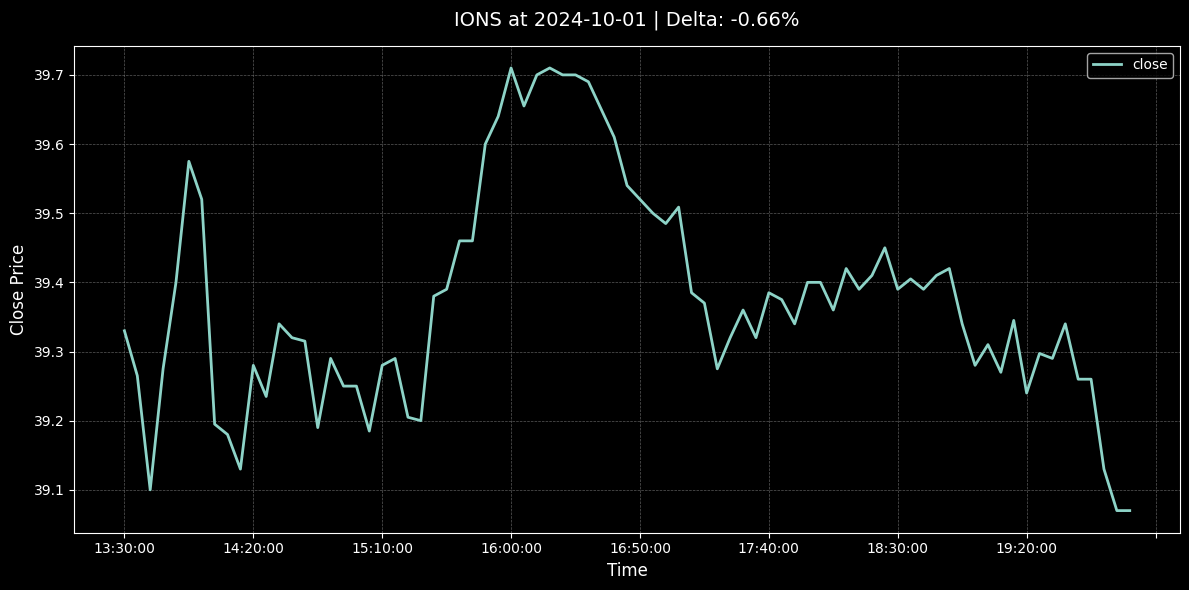

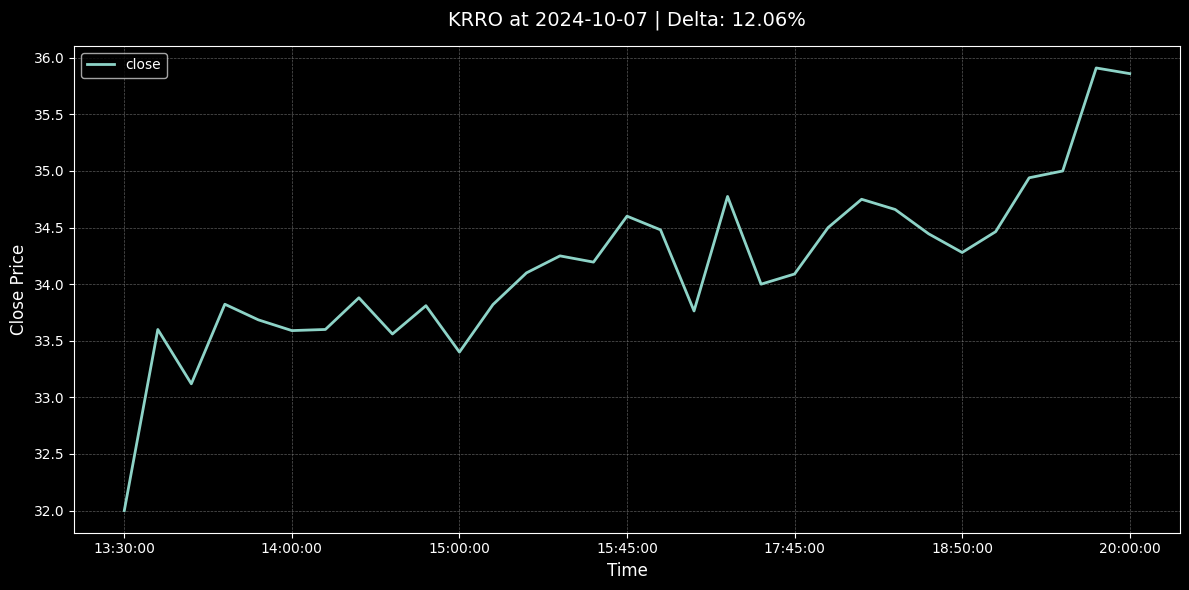

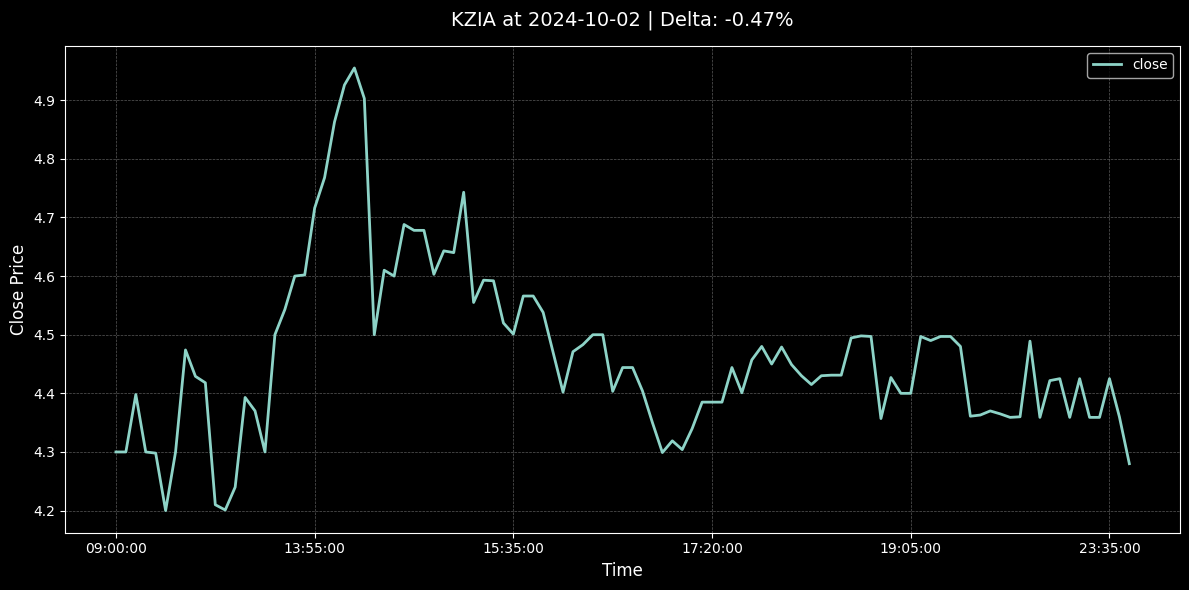

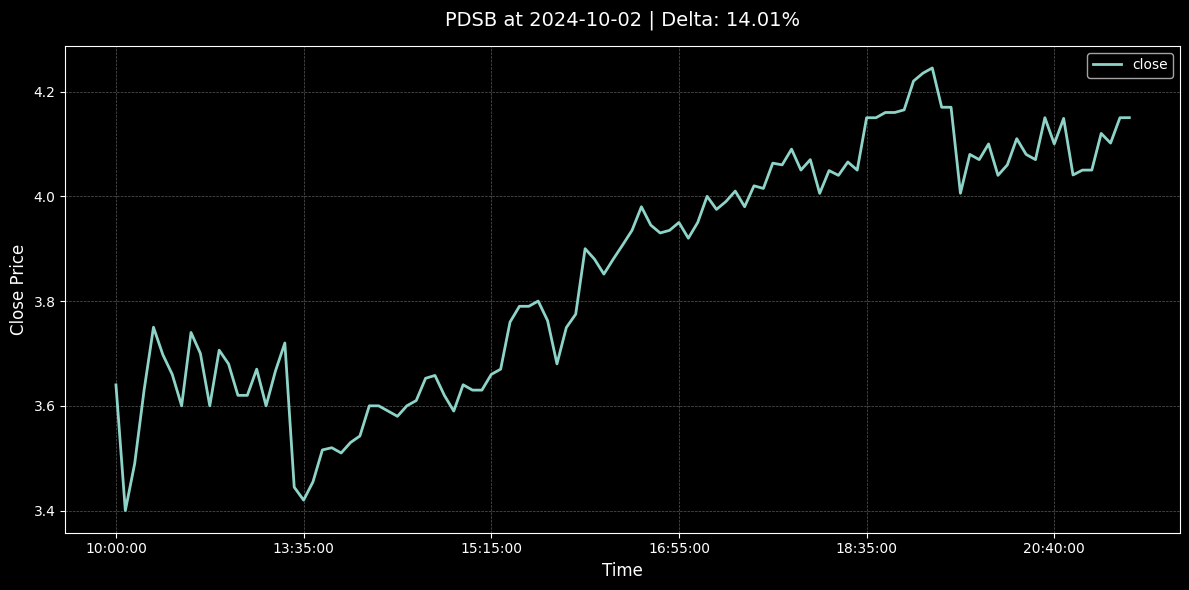

ERROR: No data for  PHVS 2024-10-05


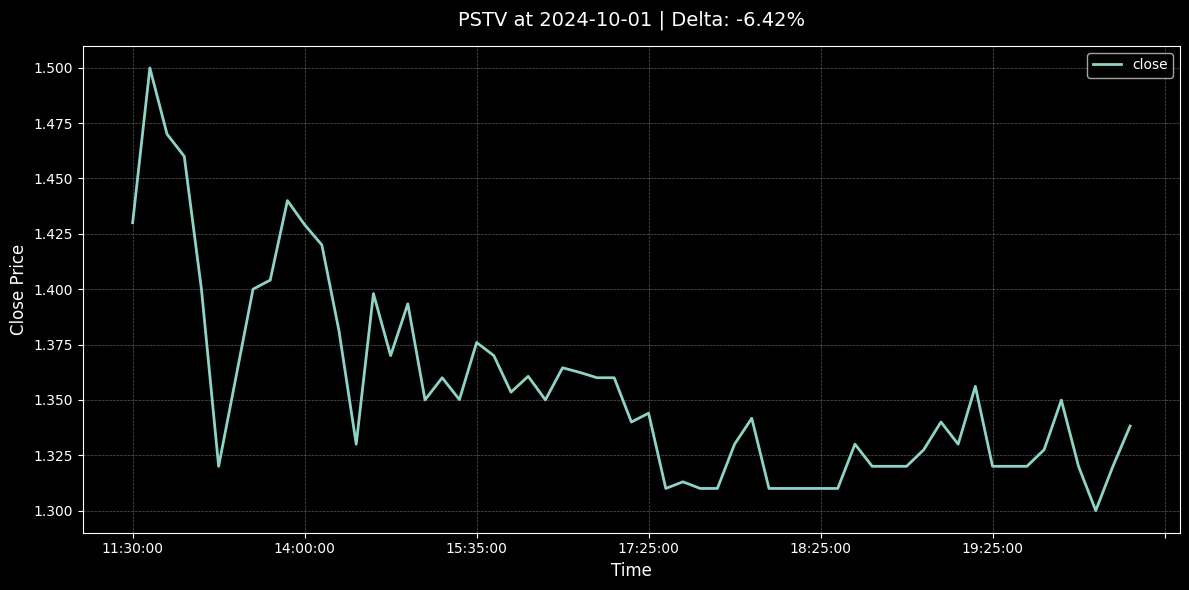

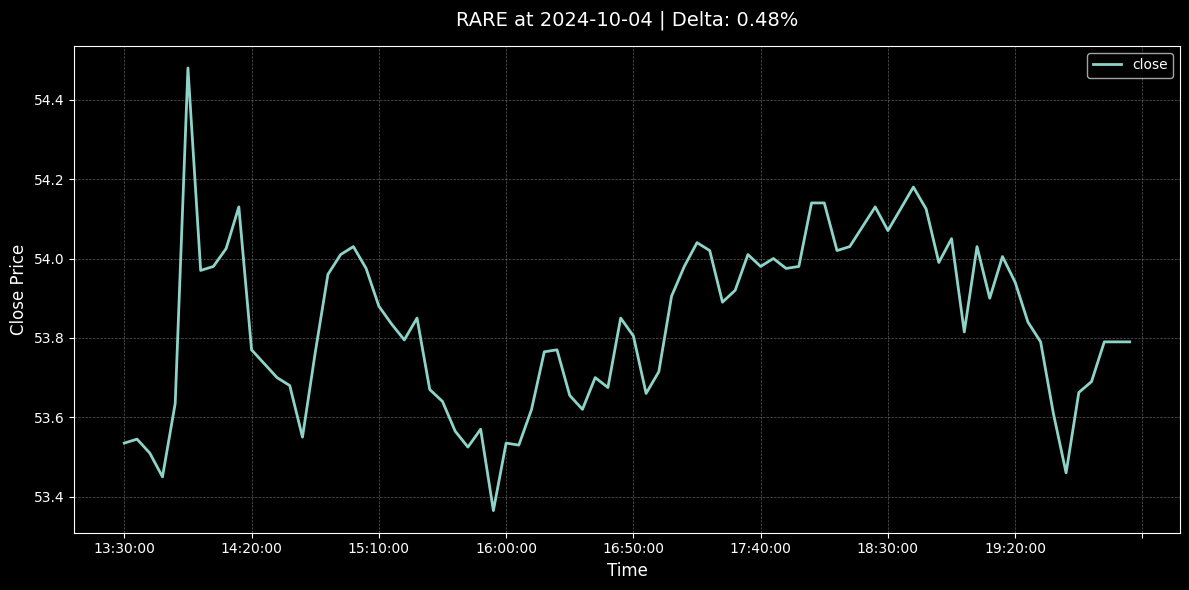

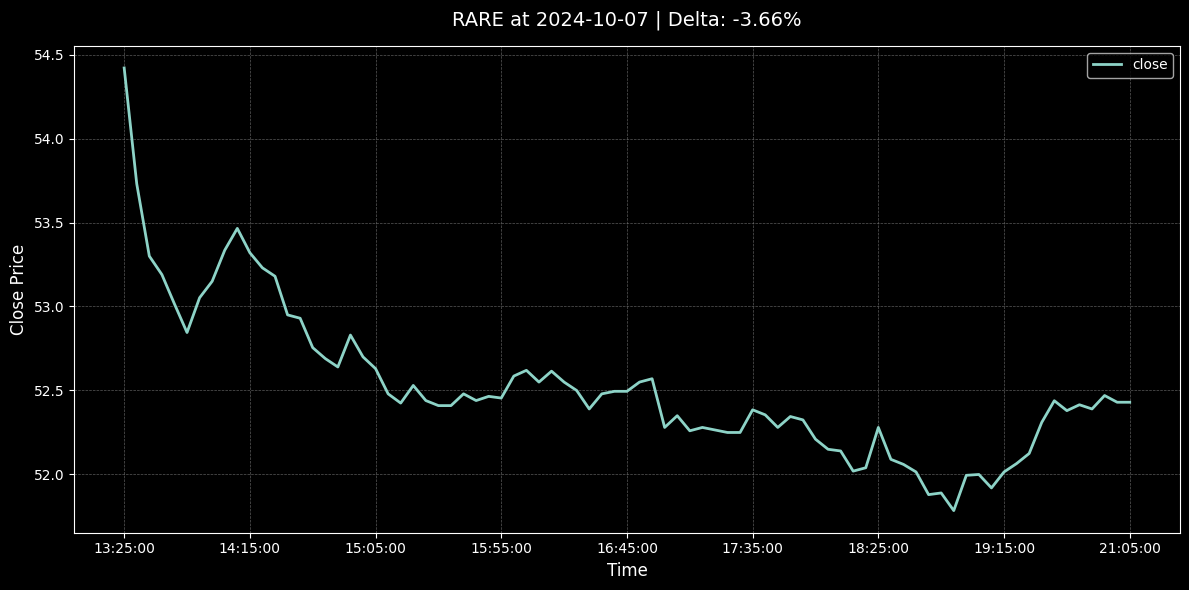

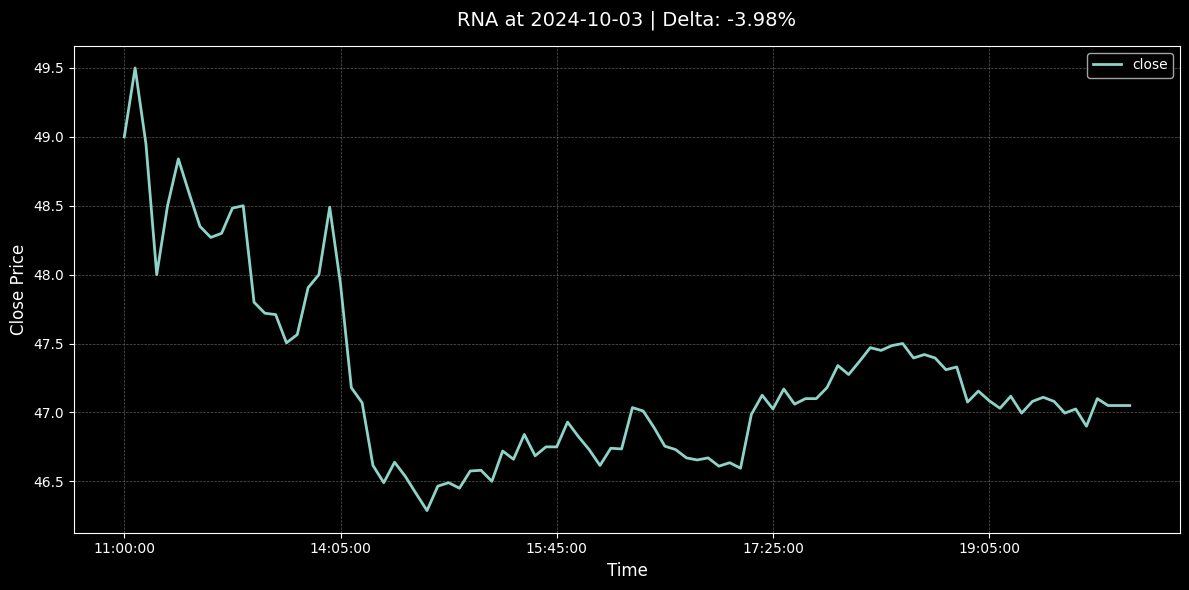

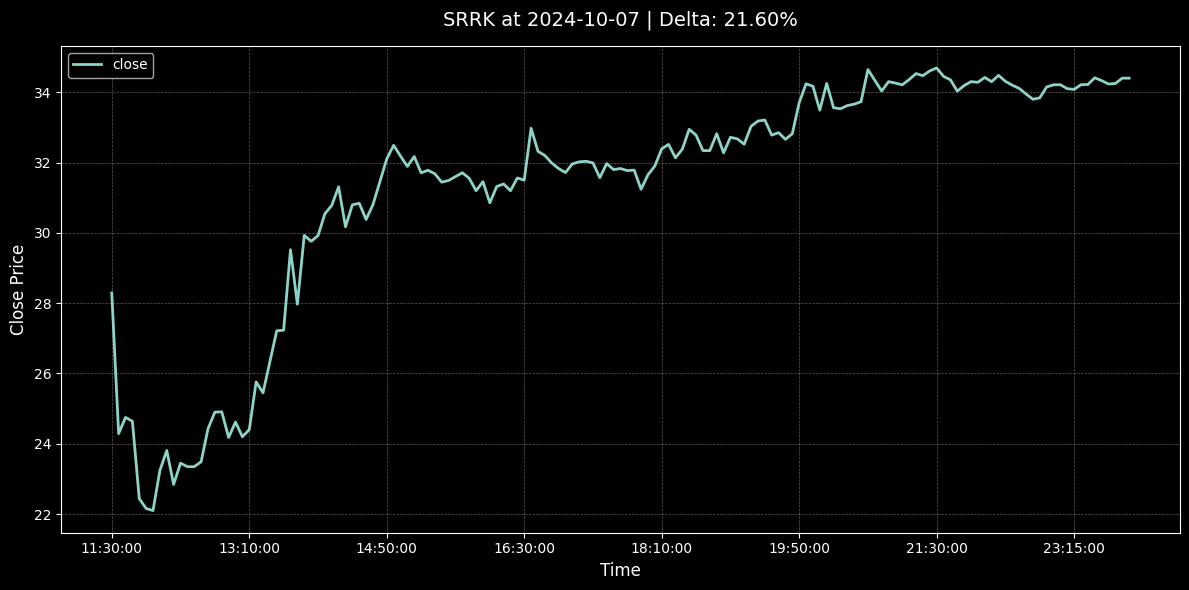

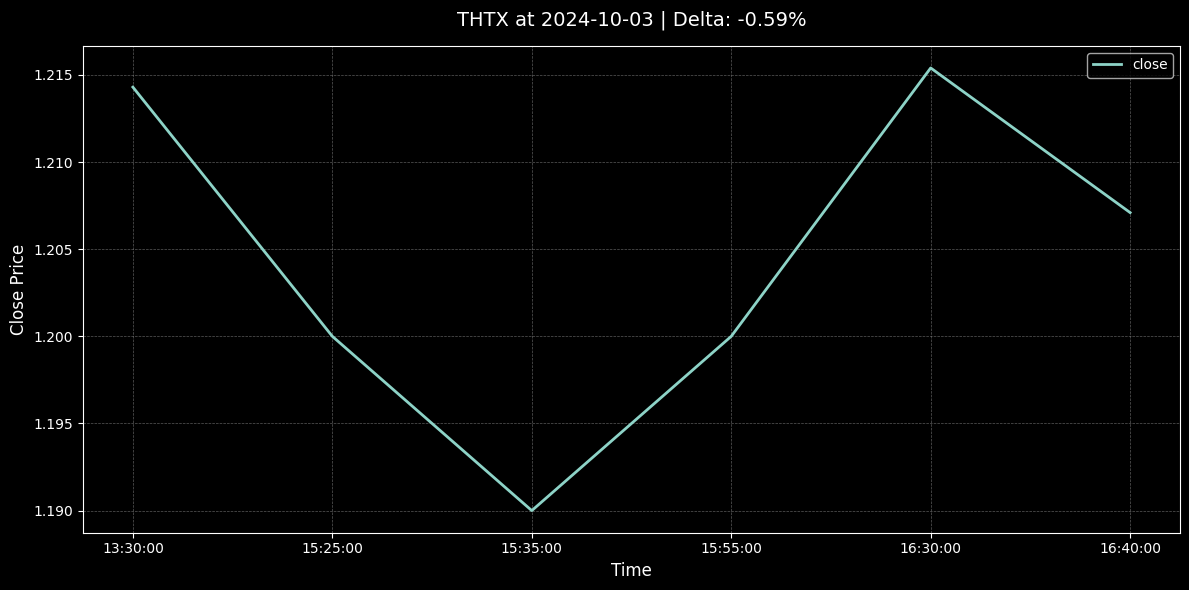

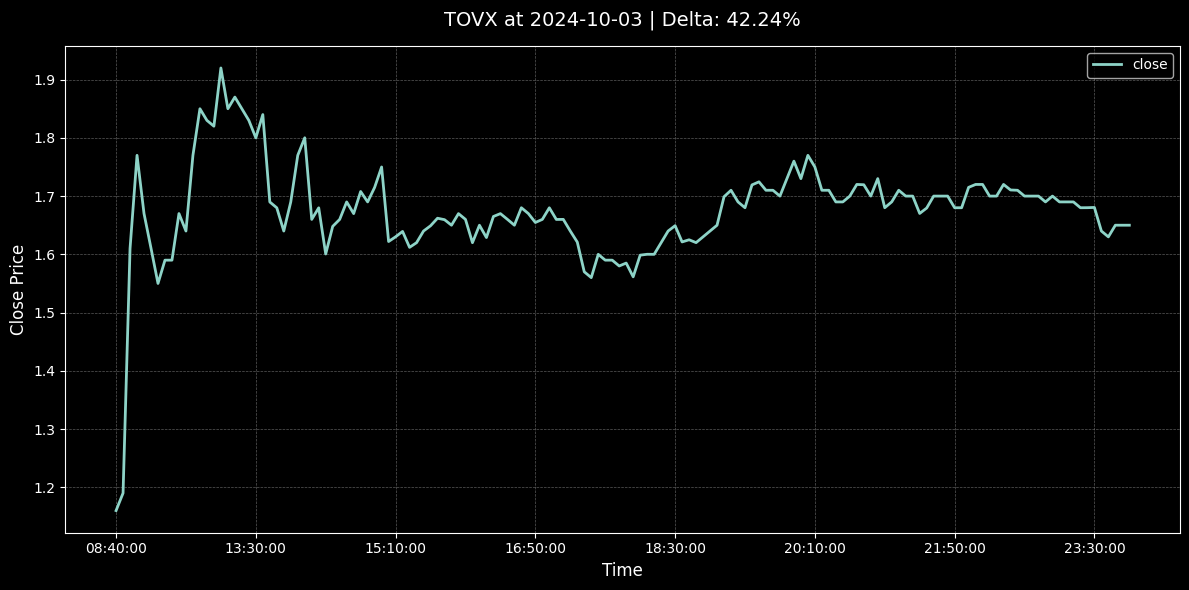

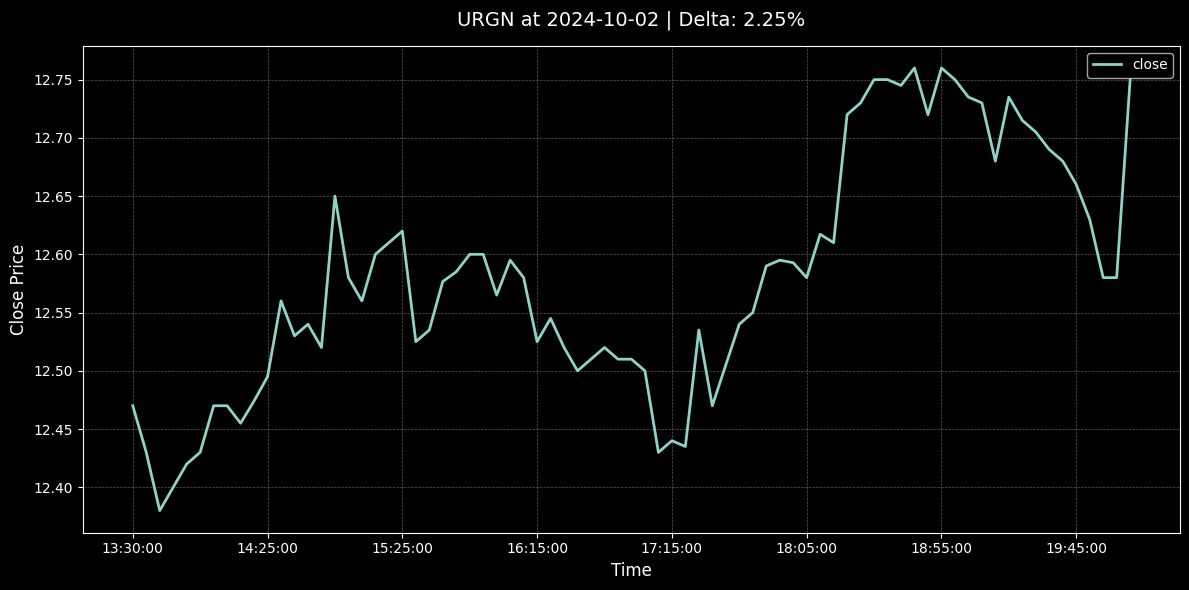

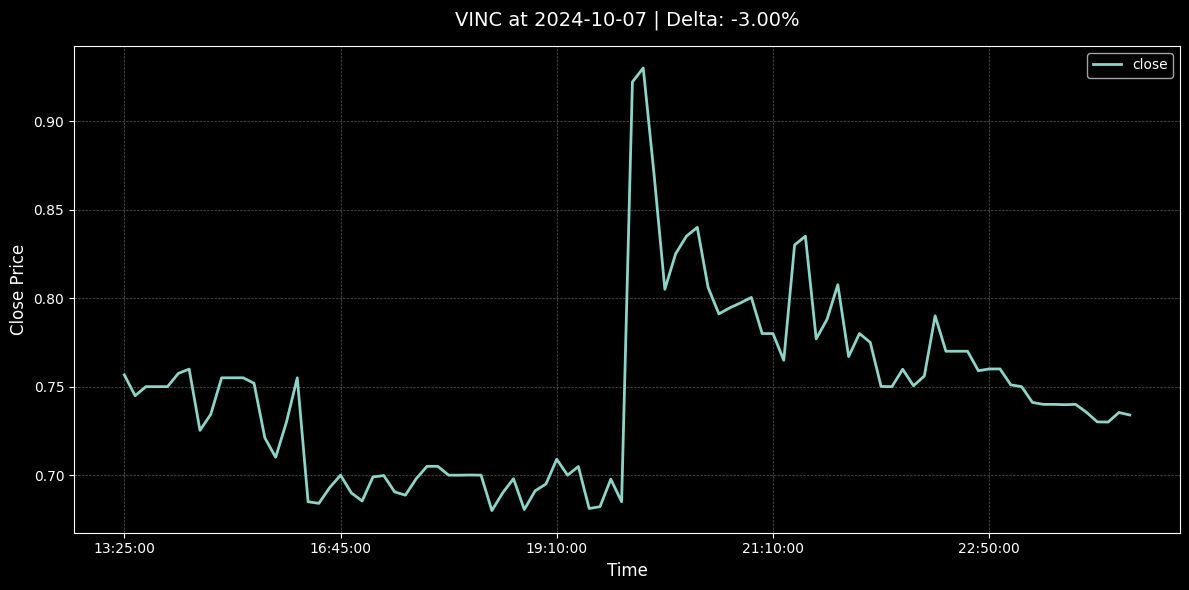

In [132]:
for data in stock_data:

    df1 = pd.DataFrame(data["data"])

    if df1.empty:
        print("ERROR: No data for ", data["ticker"], data["date"])
        continue
    df1["timestamp"] = pd.to_datetime(df1["timestamp"], unit="ms")
    df1["timestamp"] = df1["timestamp"].dt.strftime("%H:%M:%S")
    diff = ((df1["close"].iloc[-1] - df1["close"].iloc[0]) / df1["close"].iloc[0]) * 100
    # Plot the data
    ax = df1.plot(
        x="timestamp",
        y="close",
        figsize=(12, 6),
        linewidth=2,
    )
    ax.set_title(
        f"{data['ticker']} at {data['date']} | Delta: {diff:.2f}%", fontsize=14, pad=15
    )
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Close Price", fontsize=12)

    # Customize appearance
    ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

## Next: Find the ones with the highest intraday delta and check the release that triggered it 

1. Try to do basic NLP sentiment analysis